## load data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.dates as mdates

## Latent

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'latent_heat_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['surface_upward_latent_heat_flux']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['surface_upward_latent_heat_flux']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['surface_upward_latent_heat_flux']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['surface_upward_latent_heat_flux']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['surface_upward_latent_heat_flux']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['surface_upward_latent_heat_flux']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['surface_upward_latent_heat_flux']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['surface_upward_latent_heat_flux']

#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar_l = allvar.where(landmask == 1)
control_l = control.where(landmask == 1)
albedo_bare_l = albedo_bare.where(landmask == 1)
albedo_l = albedo.where(landmask == 1)
bare_l = bare.where(landmask == 1)
SM_albedo_l = SM_albedo.where(landmask == 1)
SM_bare_l = SM_bare.where(landmask == 1)
SM_l = SM.where(landmask == 1)

In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

In [4]:
experiments_l = {
    "AllVar": allvar_l,
    "Control": control_l,
    "Albedo_Bare": albedo_bare_l,
    "Albedo": albedo_l,
    "Bare": bare_l,
    "SM_Albedo": SM_albedo_l,
    "SM_Bare": SM_bare_l,
    "SM": SM_l
}


In [5]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments_l.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da


In [6]:
#latent data clipped to fire scars
allvar_l = clipped['AllVar']
control_l =clipped['Control']
albedo_bare_l =clipped['Albedo_Bare']
albedo_l =clipped['Albedo']
bare_l =clipped['Bare']
SM_albedo_l =clipped['SM_Albedo']
SM_bare_l =clipped['SM_Bare']
SM_l =clipped['SM']
experiments_l = {
    "All Variables": allvar_l,
    "Control": control_l,
    "Albedo + Bare": albedo_bare_l,
    "Albedo": albedo_l,
    "Bare": bare_l,
    "SM + Albedo": SM_albedo_l,
    "SM + Bare": SM_bare_l,
    "SM": SM_l
}

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

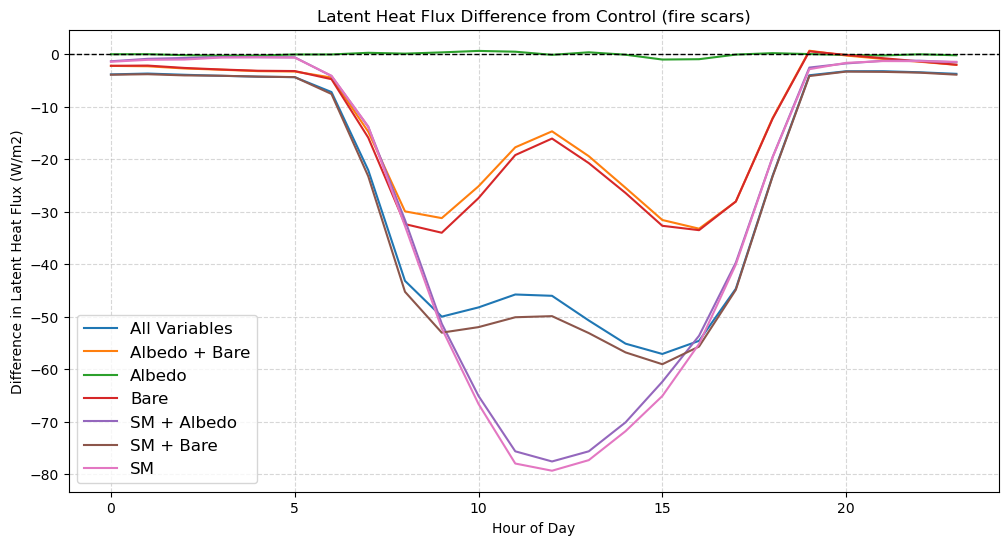

In [7]:
#compute diurnal cycle for fire scars (diff from control)
lh_series = {}
for name, da in experiments_l.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10)) #AEST
    lh_series[name] = da.mean(dim=["latitude", "longitude"], skipna=True)

lh_diurnal = {}
for name, series in lh_series.items():
    lh_diurnal[name] = series.groupby("time.hour").mean("time")

ref = lh_diurnal["Control"]

lh_diff = {}
for name, series in lh_diurnal.items():
    if name != "Control":
        #align on hour dimension 
        series, ref_aligned = xr.align(series, ref)
        lh_diff[name] = series - ref_aligned

plt.figure(figsize=(12,6))

for name, diff in lh_diff.items():
    plt.plot(diff["hour"], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("Latent Heat Flux Difference from Control (fire scars)")
plt.xlabel("Hour of Day")
plt.ylabel("Difference in Latent Heat Flux (W/m2)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
# plt.savefig("/g/data/ng72/as9583/figures/latent_heat_local.png", dpi=300, bbox_inches="tight")
plt.show()

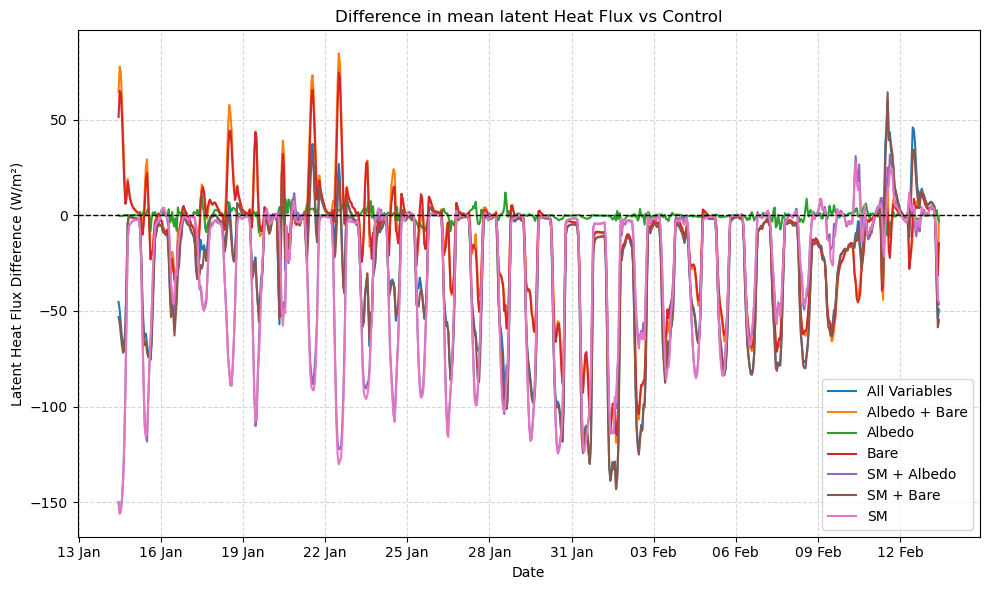

In [8]:
#diff over sim (fire scar)
control = lh_series["Control"]

plt.figure(figsize=(10,6))

for name, series in lh_series.items():
    if name == "Control":
        continue
    diff = series - control
    plt.plot(diff["time"], diff, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Latent Heat Flux Difference (W/m²)")
plt.title("Difference in mean latent Heat Flux vs Control")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  #tick every 3rd day

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


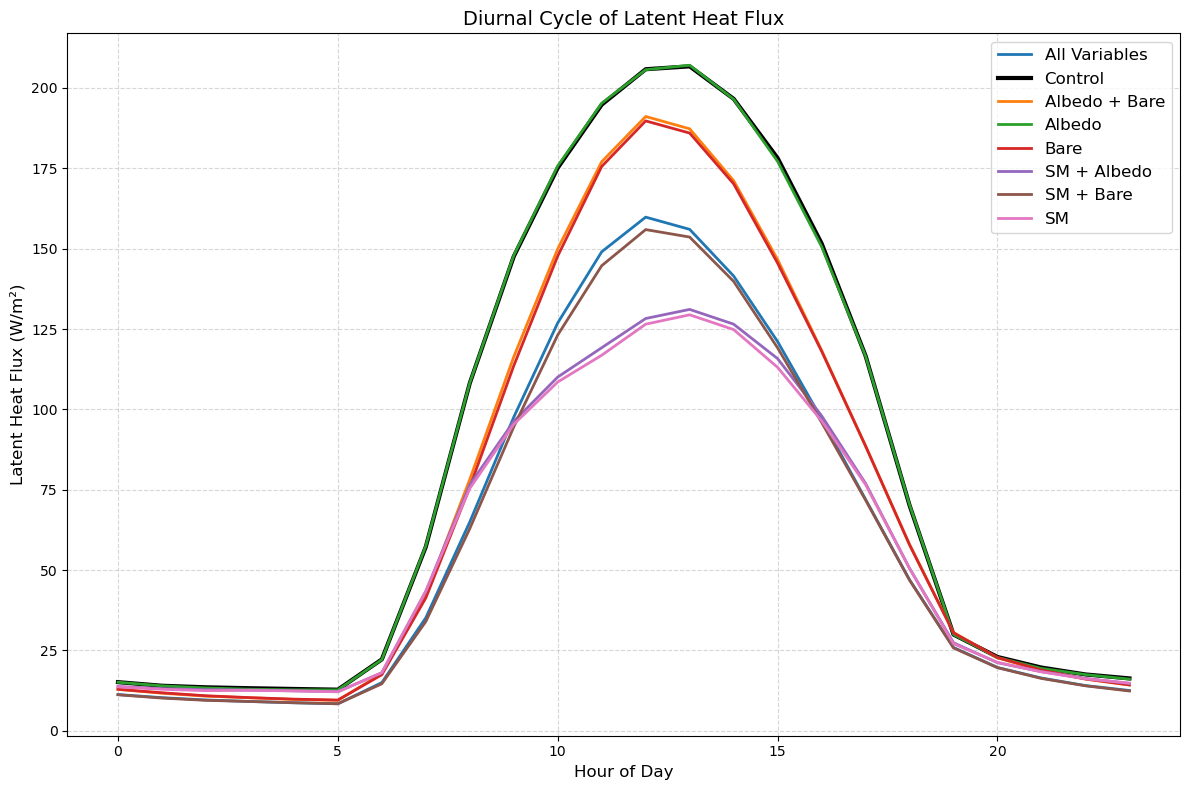

In [9]:
#compute absolute diurnal cycle
plt.figure(figsize=(12,8))

for name, series in lh_diurnal.items():
    if name == "Control": #control as black
        plt.plot(series["hour"], series.values, label=name, color="black", linewidth=3)
    else:
        plt.plot(series["hour"], series.values, label=name, linewidth=2)

plt.title("Diurnal Cycle of Latent Heat Flux", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Latent Heat Flux (W/m²)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Sensible

In [10]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'sensible_heat_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['surface_upward_sensible_heat_flux']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['surface_upward_sensible_heat_flux']

allvar_s = allvar.where(landmask == 1)
control_s = control.where(landmask == 1)
albedo_bare_s = albedo_bare.where(landmask == 1)
albedo_s = albedo.where(landmask == 1)
bare_s = bare.where(landmask == 1)
SM_albedo_s = SM_albedo.where(landmask == 1)
SM_bare_s = SM_bare.where(landmask == 1)
SM_s = SM.where(landmask == 1)

experiments_s = {
    "AllVar": allvar_s,
    "Control": control_s,
    "Albedo_Bare": albedo_bare_s,
    "Albedo": albedo_s,
    "Bare": bare_s,
    "SM_Albedo": SM_albedo_s,
    "SM_Bare": SM_bare_s,
    "SM": SM_s
}


In [11]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments_s.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da

allvar_s = clipped['AllVar']
control_s =clipped['Control']
albedo_bare_s =clipped['Albedo_Bare']
albedo_s =clipped['Albedo']
bare_s =clipped['Bare']
SM_albedo_s =clipped['SM_Albedo']
SM_bare_s=clipped['SM_Bare']
SM_s =clipped['SM']

In [12]:
#sensible heat fire scar dict
experiments_s = {
    "All Variables": allvar_s,
    "Control": control_s,
    "Albedo + Bare": albedo_bare_s,
    "Albedo": albedo_s,
    "Bare": bare_s,
    "SM + Albedo": SM_albedo_s,
    "SM + Bare": SM_bare_s,
    "SM": SM_s
}

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

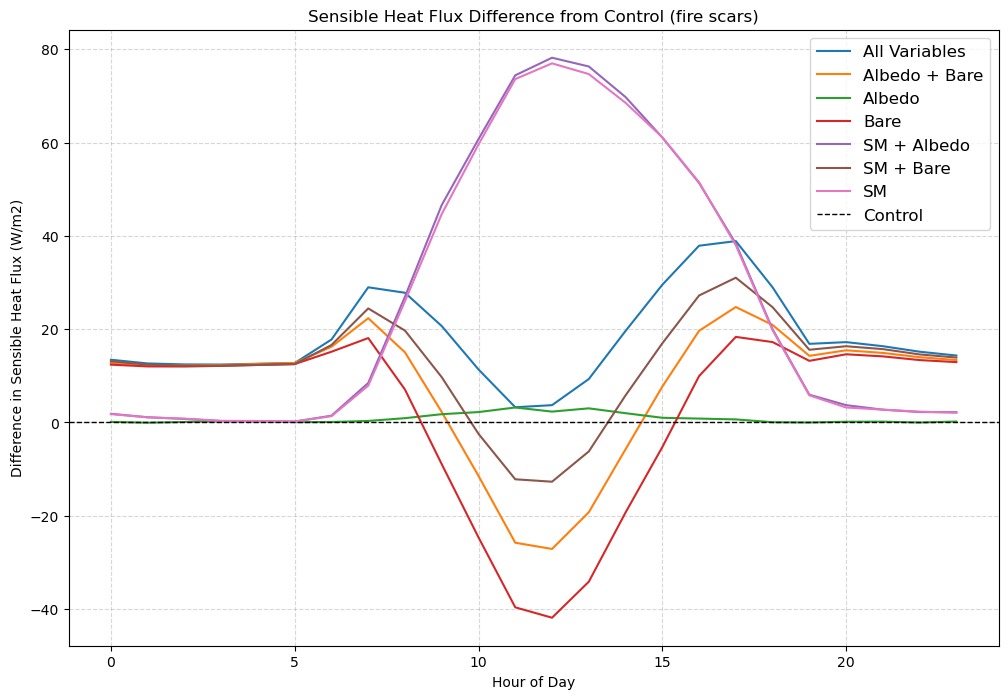

In [23]:
#diurnal cycle diff from control

sh_series = {}
for name, da in experiments_s.items():
    da = da.assign_coords(time=da.time + pd.Timedelta(hours=10)) #AEST
    sh_series[name] = da.mean(dim=["latitude", "longitude"], skipna=True)

sh_diurnal = {}
for name, series in sh_series.items():
    sh_diurnal[name] = series.groupby("time.hour").mean("time")

ref = sh_diurnal["Control"]

sh_diff = {}
for name, series in sh_diurnal.items():
    if name != "Control":
        #align on hour dimension
        series, ref_aligned = xr.align(series, ref)
        sh_diff[name] = series - ref_aligned

plt.figure(figsize=(12,8))

for name, diff in sh_diff.items():
    plt.plot(diff["hour"], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = "Control")
plt.title("Sensible Heat Flux Difference from Control (fire scars)")
plt.xlabel("Hour of Day")
plt.ylabel("Difference in Sensible Heat Flux (W/m2)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
# plt.savefig("/g/data/ng72/as9583/figures/sensible_heat_local.png", dpi=300, bbox_inches="tight")
plt.show()

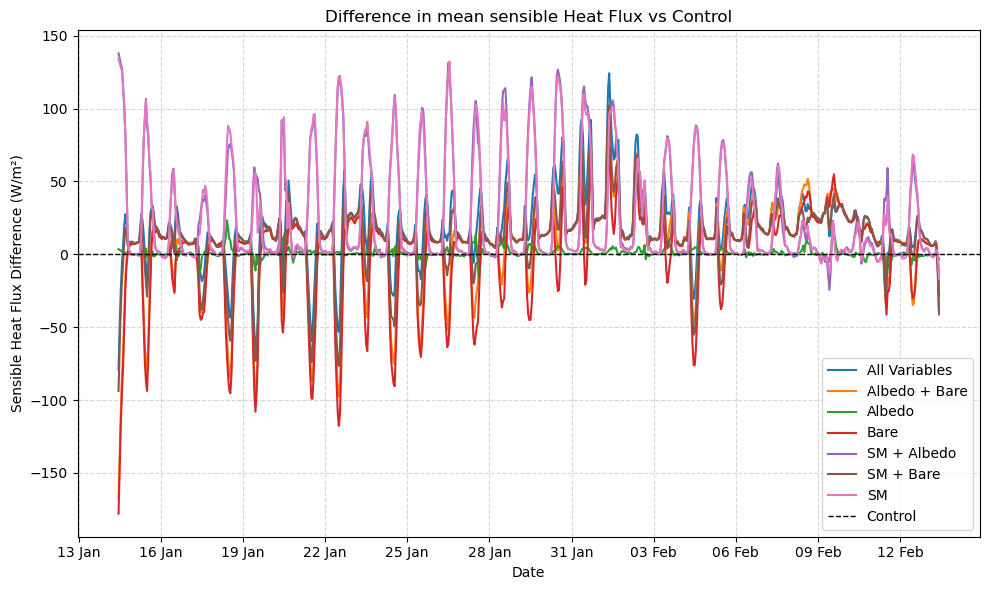

In [40]:
#diff over sim

control = sh_series["Control"]

plt.figure(figsize=(10,6))

for name, series in sh_series.items():
    if name == "Control":
        continue
    diff = series - control
    plt.plot(diff["time"], diff, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
plt.xlabel("Date")
plt.ylabel("Sensible Heat Flux Difference (W/m²)")
plt.title("Difference in mean sensible Heat Flux vs Control")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))  # tick each day

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


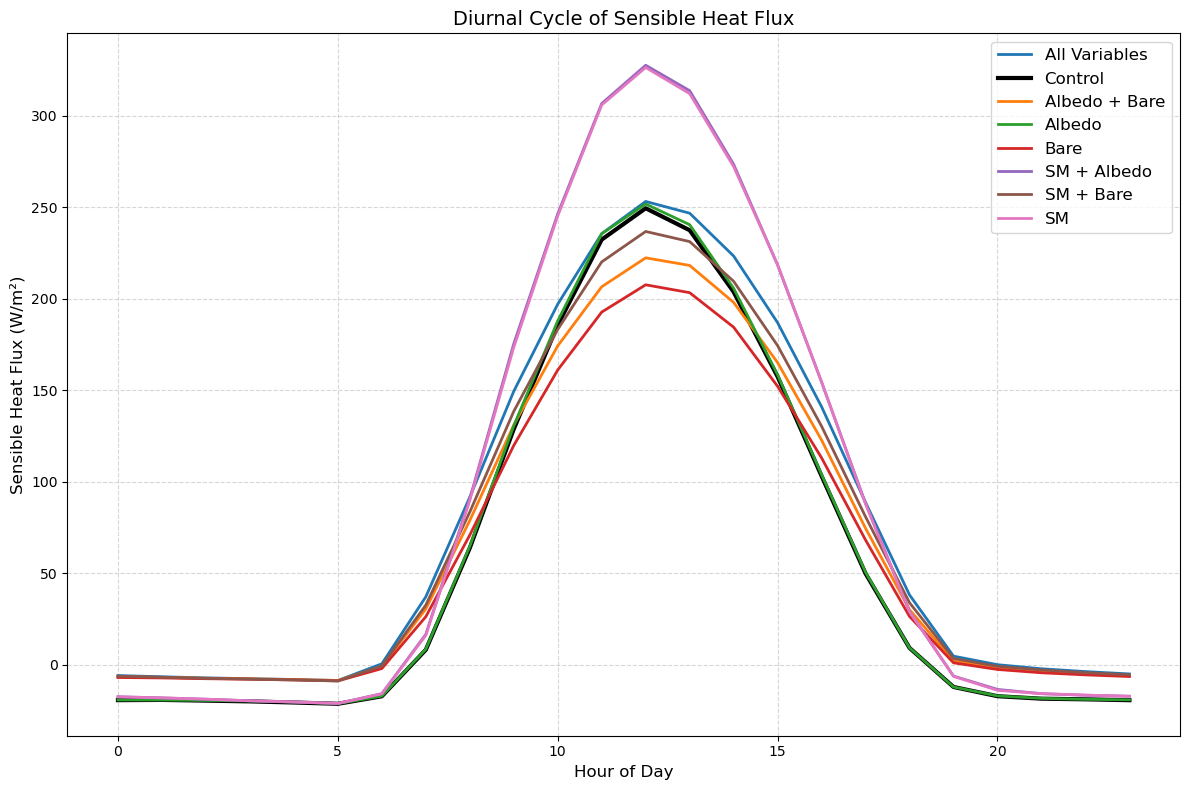

In [25]:
#absolute diurnal cycle
plt.figure(figsize=(12,8))

for name, series in sh_diurnal.items():
    if name == "Control":
        plt.plot(series["hour"], series.values, label=name, color="black", linewidth=3)
    else:
        plt.plot(series["hour"], series.values, label=name, linewidth=2)

plt.title("Diurnal Cycle of Sensible Heat Flux", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Sensible Heat Flux (W/m²)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## joined

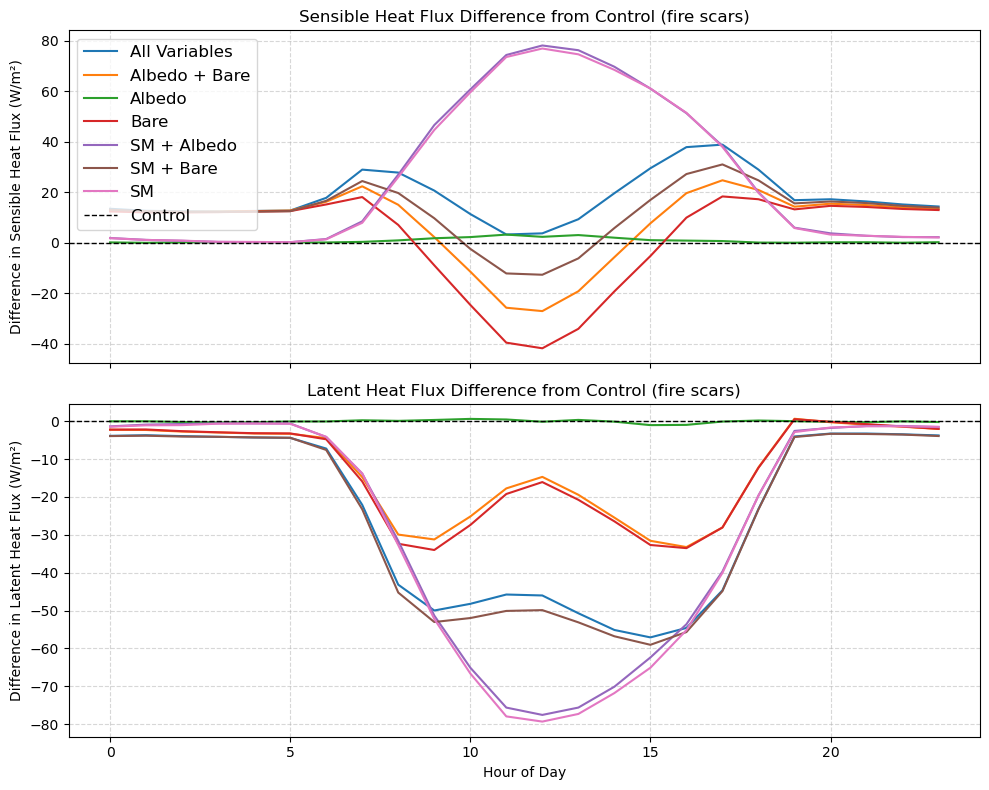

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

#sensible
for name, diff in sh_diff.items():
    axes[0].plot(diff["hour"], diff.values, label=f"{name}")

axes[0].axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
axes[0].set_ylabel("Difference in Sensible Heat Flux (W/m²)")
axes[0].set_title("Sensible Heat Flux Difference from Control (fire scars)")
axes[0].legend(fontsize=12, loc = 'upper left')
axes[0].grid(True, linestyle="--", alpha=0.5)

#latent
for name, diff in lh_diff.items():
    axes[1].plot(diff["hour"], diff.values, label=f"{name}")

axes[1].axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Difference in Latent Heat Flux (W/m²)")
axes[1].set_title("Latent Heat Flux Difference from Control (fire scars)")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/figures/heat_flux_differences.png", dpi=300, bbox_inches="tight")
plt.show()


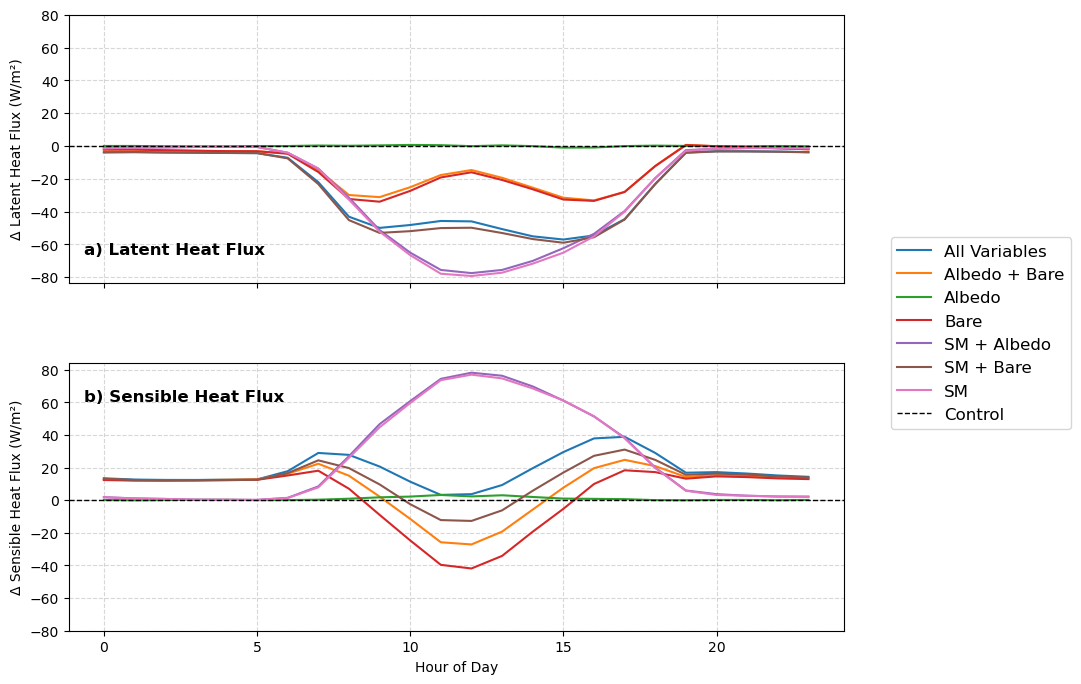

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.3})

#sensible
for name, diff in sh_diff.items(): #in AEST from above
    axes[1].plot(diff["hour"], diff.values, label=f"{name}")

axes[1].axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
axes[1].set_ylabel("Δ Sensible Heat Flux (W/m²)")
axes[1].legend(
    fontsize=12,
    loc='upper left',                
    bbox_to_anchor=(1.05, 1.5),       
    ncol=1                        
)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].text(
    0.02, 0.9, "b) Sensible Heat Flux",         
    transform=axes[1].transAxes,
    fontsize=12,
    fontweight='bold',
    verticalalignment='top'
)


#latent 
for name, diff in lh_diff.items(): #in AEST as above
    axes[0].plot(diff["hour"], diff.values, label=f"{name}")

axes[0].axhline(0, color="k", linestyle="--", linewidth=1, label = 'Control')
axes[1].set_xlabel("Hour of Day")
axes[0].set_ylabel("Δ Latent Heat Flux (W/m²)")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].text(
    0.02, 0.15, "a) Latent Heat Flux",      
    transform=axes[0].transAxes,           
    fontsize=12,
    fontweight='bold',
    verticalalignment='top'
)

#make axis the same
yticks = np.arange(-80,100, 20)
axes[0].set_yticks(yticks)
axes[1].set_yticks(yticks)

# plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/new_analysis/figures/heat_flux_differences.png", dpi=300, bbox_inches="tight")
plt.show()


## Bowen ratio

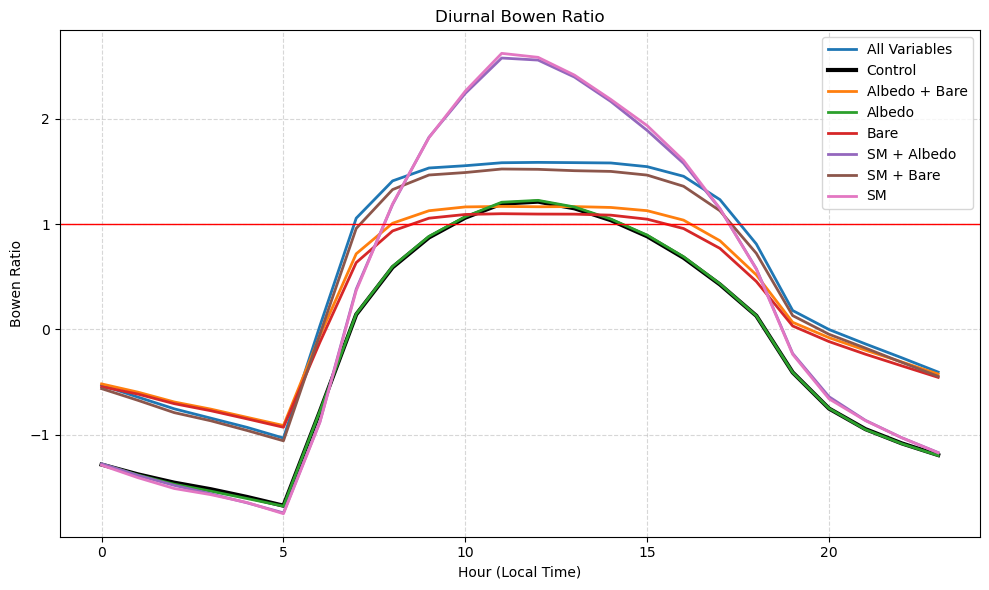

In [32]:
#Bowen ratio
ratio_diurnal = {}

for name in sh_diurnal.keys(): #in AEST
    sh, lh = xr.align(sh_diurnal[name], lh_diurnal[name], join="inner")
    ratio_diurnal[name] = sh / lh

plt.figure(figsize=(10,6))
for name, ratio in ratio_diurnal.items():
    if name == "Control": ###plot control in black
        plt.plot(ratio["hour"], ratio, label=name, color="black", linewidth=3)
    else:
        plt.plot(ratio["hour"], ratio.values, label=name, linewidth=2)

plt.axhline(y=1, color="red", linestyle="-", linewidth=1) #plot line at 1 to show shift between H and LE

plt.xlabel("Hour (Local Time)")
plt.ylabel("Bowen Ratio")
plt.title("Diurnal Bowen Ratio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# > 1 means more sensible heat dominant, < 1 means more latent heat dominant

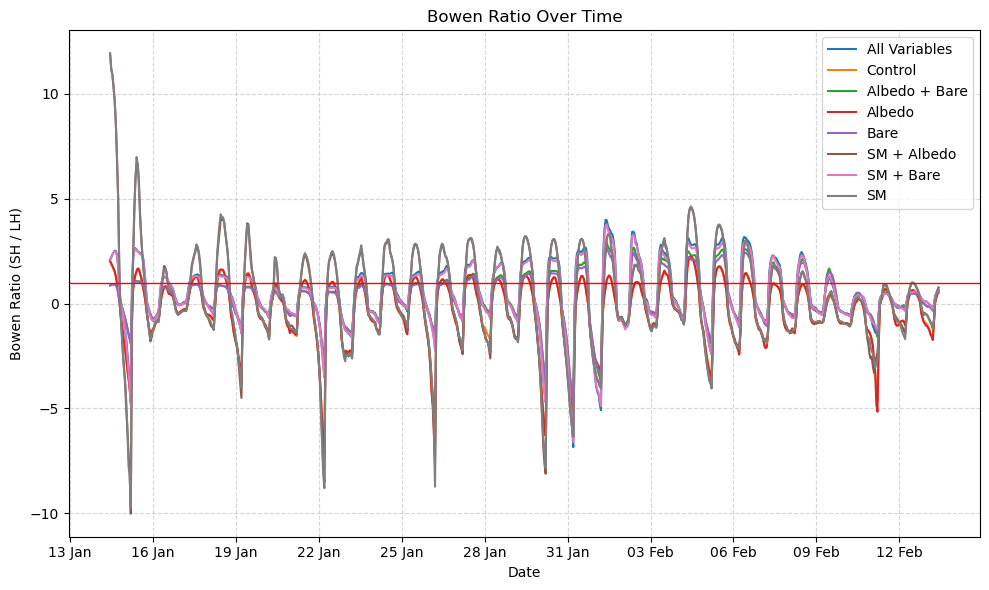

In [35]:
plt.figure(figsize=(10,6))

bowen_series = {}

for name in sh_series.keys():
    sh = sh_series[name]
    lh = lh_series[name]

    sh, lh = xr.align(sh, lh, join="inner")
    
    #Compute Bowen ratio
    bowen = sh / lh
    bowen_series[name] = bowen
    
    plt.plot(bowen["time"], bowen, label=name)

plt.axhline(1, color="red", linestyle="-", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Bowen Ratio (SH / LH)")
plt.title("Bowen Ratio Over Time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3)) #every 3rd date

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### specific dates

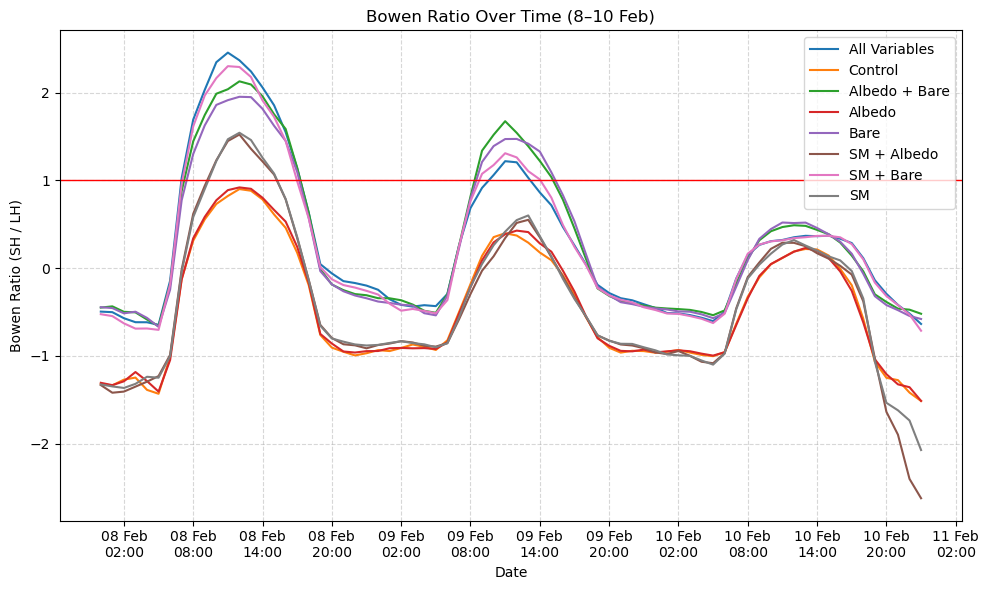

In [36]:
#8-10 feb
start = np.datetime64("2020-02-08T00:00")
end   = np.datetime64("2020-02-10T23:59")

plt.figure(figsize=(10,6))

bowen_series = {}

for name in sh_series.keys():
    sh = sh_series[name] 
    lh = lh_series[name]

    sh, lh = xr.align(sh, lh, join="inner")

    sh_sel = sh.sel(time=slice(start, end))
    lh_sel = lh.sel(time=slice(start, end))

    #bowen
    bowen = sh_sel / lh_sel
    bowen_series[name] = bowen

    plt.plot(bowen["time"], bowen, label=name)

plt.axhline(1, color="red", linestyle="-", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Bowen Ratio (SH / LH)")
plt.title("Bowen Ratio Over Time (8–10 Feb)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b\n%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


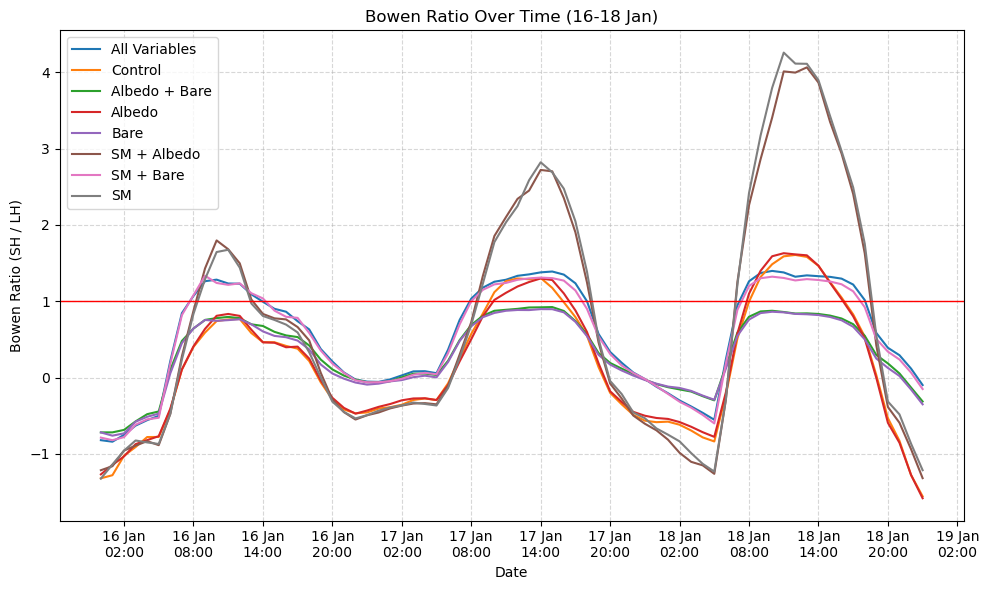

In [38]:
#jan 16-18
start = np.datetime64("2020-01-16T00:00")
end   = np.datetime64("2020-01-18T23:59")

plt.figure(figsize=(10,6))

bowen_series = {}

for name in sh_series.keys():
    sh = sh_series[name] 
    lh = lh_series[name]

    sh, lh = xr.align(sh, lh, join="inner")

    sh_sel = sh.sel(time=slice(start, end))
    lh_sel = lh.sel(time=slice(start, end))

    #bowen
    bowen = sh_sel / lh_sel
    bowen_series[name] = bowen

    plt.plot(bowen["time"], bowen, label=name)

plt.axhline(1, color="red", linestyle="-", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Bowen Ratio (SH / LH)")
plt.title("Bowen Ratio Over Time (16-18 Jan)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b\n%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

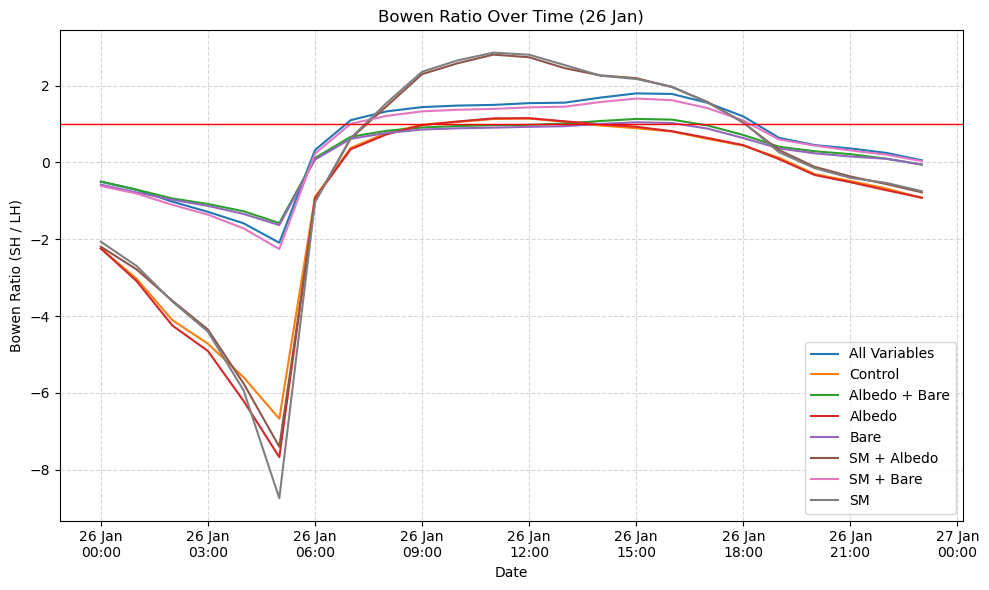

In [39]:
#26 Jan
start = np.datetime64("2020-01-26T00:00")
end   = np.datetime64("2020-01-26T23:59")

plt.figure(figsize=(10,6))

bowen_series = {}

for name in sh_series.keys():
    sh = sh_series[name] 
    lh = lh_series[name]

    sh, lh = xr.align(sh, lh, join="inner")

    sh_sel = sh.sel(time=slice(start, end))
    lh_sel = lh.sel(time=slice(start, end))

    #bowen
    bowen = sh_sel / lh_sel
    bowen_series[name] = bowen

    plt.plot(bowen["time"], bowen, label=name)

plt.axhline(1, color="red", linestyle="-", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Bowen Ratio (SH / LH)")
plt.title("Bowen Ratio Over Time (26 Jan)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d %b\n%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
